# Convolutional Neural Network


In [2]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import time
%matplotlib inline

### What is a convolutional neural network?

A convolutional neural network differs from a perceptron in that it has additional layers dedicated to compressing the input into more easily processable forms, while still keeping features critical for prediction. This is accomplished with the use of a kernel matrix. The kernel matrix is some matrix with a size and entries determined by the user to be multiplied by certain regions of the input matrix, and whose output is then entered into the output matrix. An activation function is then applied to the output matrix.

For example, if our input matrix was a 6 x 6 x 1 x 1 matrix:

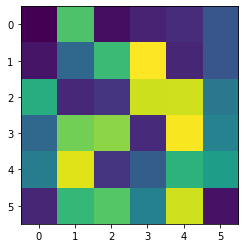

In [3]:
Input = np.array([[[np.random.uniform(0,1,6)]],
                  [[np.random.uniform(0,1,6)]],
                  [[np.random.uniform(0,1,6)]],
                  [[np.random.uniform(0,1,6)]],
                  [[np.random.uniform(0,1,6)]],
                  [[np.random.uniform(0,1,6)]]])
Input = np.reshape(Input,[1,6,6,1])
plt.imshow(Input[0,:,:,0])

We can choose a kernal matrix of size 3 x 3 to multiply by each 3 x 3 region of our input matrix, and place the resulting values into a new matrix.

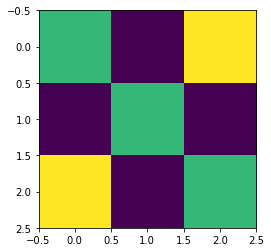

In [4]:
kernel = np.array([ [  [[0.5]],[[0]],[[0.75]]  ],
                    [  [[0]],[[0.5]],[[0]]  ],
                    [  [[0.75]],[[0]],[[0.5]]  ] ])
plt.imshow(kernel[:,:,0,0]) 

Let's consider the entries in the first 3 rows and columns of our Input matrix:

In [5]:
product = np.matmul(Input[0,:3,:3,0],kernel[:,:,0,0])

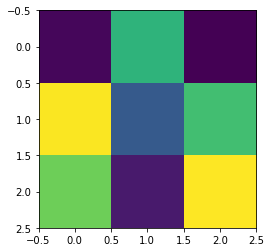

In [6]:
plt.imshow(product)

The values in this matrix would then be summed and would be the first entry in the output matrix. We can use a tensorflow method to visualize what this output matrix would look like.

2021-12-01 16:39:43.665447: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


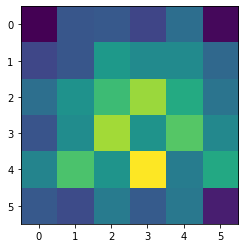

In [7]:
Input = tf.constant(Input)       # We need a 4d tensor to do a convolutional operation
kernel = tf.constant(kernel)     # Our kernel needs to be a tensor as well
kernel = tf.cast(kernel,tf.float64)     # Our input matrix and kernel need to be tensors of the same data type
ex_conv = tf.nn.conv2d(Input,kernel,padding = 'SAME',strides = [1])

plt.imshow(ex_conv[0,:,:,0])

If we wanted to reduce the dimebnsions of our matrix, we could set padding = 'VALID' such that our output tensor is smaller.

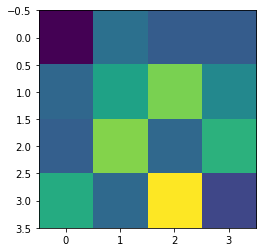

In [8]:
small_conv = tf.nn.conv2d(Input,kernel,padding = 'VALID',strides = [1])

plt.imshow(small_conv[0,:,:,0])

In this example, we simply chose a random kernel and applied it to a random matrix. When being applied to actual data however, there are different kernel matrices one can choose to select for specific features, like an edge, a corner, etc. A convolutional layer can apply multiple such filters to some input data at a time and combine this information to create useful insights about the data. When we apply our convolutional layers to the MNIST data set, we'll let tensorflow choose the kernel matrices for us, as they'll do a much better job at it than we will.

In an actual convolutional layer, an activation function would also be applied to this output matrix. A commonly used activation function (which we will be using) is the relu function, which stands for rectified linear unit. This function returns the maximum between the max value within a certain space and 0, such that the result has no negative values in it. We use a relu function because it is a nonlinear transformation, which may help us classify our data by separating it, and it is fast to compute without suffering from a vanishing gradient (a topic we will not discuss here).

Now that we have an idea of what a convolutional layer does, let's load in the data and take a look at it!

In [9]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

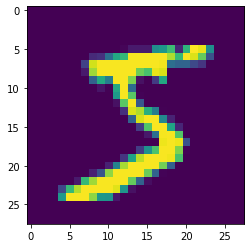

In [10]:
image = x_train[0]
plt.imshow(image)

In [11]:
# Here we find the shape of our input images so we can tell our model the shape of our input data
image.shape

(28, 28)

Before we pass the data into our model, we'll need to preprocess it:

In [12]:
# Model / data parameters
num_classes = 10   # Numbers 0 through 9
input_shape = (28, 28, 1)

# Scale images to the [0, 1] range
x_train = x_train.astype("float32") / 255
x_test = x_test.astype("float32") / 255
# Make sure images have shape (28, 28, 1)
x_train = np.expand_dims(x_train, -1)
x_test = np.expand_dims(x_test, -1)
print("x_train shape:", x_train.shape)
print(x_train.shape[0], "train samples")
print(x_test.shape[0], "test samples")


# convert class vectors to binary class matrices
y_train = tf.keras.utils.to_categorical(y_train, num_classes)
y_test = tf.keras.utils.to_categorical(y_test, num_classes)

x_train shape: (60000, 28, 28, 1)
60000 train samples
10000 test samples


The two layers we'll be using are the Conv2D layer and the MaxPooling2D layer. TheConv2D layer returns a tensor with the specified dimensionality after being processed by a kernel of the specified size. The output is also determined by the activation function used for the kernel. In this case, we'll be using the 'relu' activation, which is the rectified linear unit activation function. This activation function takes in the input region and outputs the maximum between the max value in the input region and 0. 

The MaxPooling2D layer simply finds the maximum value in the designated pool size and stores this value in a new tensor. The size of the output tensor is dependent on both the pool size and the 'strides' size. The strides argument determines how the pool is shifted over each dimension.

The Flatten layer takes the data from the previous layer and compiles it all into one dimension, as seen in this visualization:

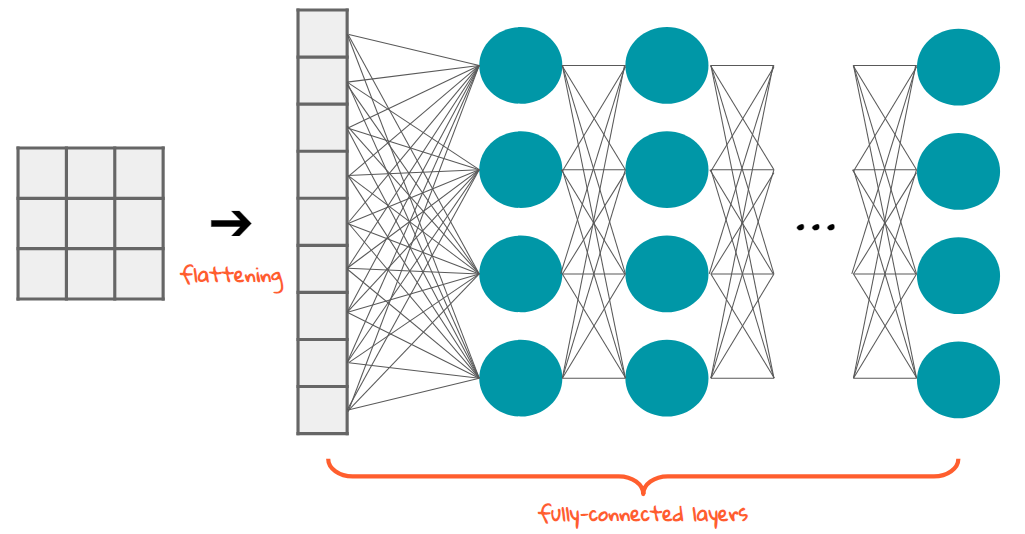

The Dropout layer randomly sets values in the input vector to 0 according to the frequency provided. Values not set to 0 are scaled by 1/(1 - rate) such that the sum over all inputs is unchanged.

The Dense layer in our model performs matrix multiplication on our data from the previous layer to generate a vector of data the same size as the input data, and whose values are each influenced by every data value from the previous layer. This layer is a fully connected layer, and can be seen in the above image. We will use a "softmax" activation for this layer, as it turns the input vector into a probability distribution, which will give us our final prediction.

In [13]:
model = keras.Sequential(
    [
        keras.Input(shape=input_shape),   # Tell the model what the shape of our data is
        layers.Conv2D(32, kernel_size=(3, 3), activation="relu"),    # Our first CNN layer has a kernel size of (3,3)
        layers.MaxPooling2D(pool_size=(2, 2)),   # We apply a MaxPooling2D layer with a pool size of 2x2
        layers.Conv2D(64, kernel_size=(3, 3), activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Flatten(),      # Takes our data and combines it into one dimension
        layers.Dropout(0.5),   # Sets half of data to 0, scales rest of data accordingly
        layers.Dense(num_classes, activation="softmax"),  # Dense layer to find probability distribution of data
    ]
)

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 13, 13, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 11, 11, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 5, 5, 64)         0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 1600)              0         
                                                                 
 dropout (Dropout)           (None, 1600)              0

In [16]:
batch_size = 100
epochs = 10

start = time.time()

model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, validation_split=0.1)

end = time.time()

print(end - start,"seconds to run with", epochs,"epochs and", batch_size,"images per batch")

Epoch 1/10
540/540 [==============================] - 14s 26ms/step - loss: 0.0311 - accuracy: 0.9900 - val_loss: 0.0285 - val_accuracy: 0.9935
Epoch 2/10
540/540 [==============================] - 14s 25ms/step - loss: 0.0297 - accuracy: 0.9902 - val_loss: 0.0270 - val_accuracy: 0.9932
Epoch 3/10
540/540 [==============================] - 14s 26ms/step - loss: 0.0274 - accuracy: 0.9911 - val_loss: 0.0320 - val_accuracy: 0.9918
Epoch 4/10
540/540 [==============================] - 14s 26ms/step - loss: 0.0258 - accuracy: 0.9917 - val_loss: 0.0289 - val_accuracy: 0.9923
Epoch 5/10
540/540 [==============================] - 14s 27ms/step - loss: 0.0252 - accuracy: 0.9916 - val_loss: 0.0273 - val_accuracy: 0.9927
Epoch 6/10
540/540 [==============================] - 15s 28ms/step - loss: 0.0242 - accuracy: 0.9919 - val_loss: 0.0257 - val_accuracy: 0.9922
Epoch 7/10
540/540 [==============================] - 14s 27ms/step - loss: 0.0242 - accuracy: 0.9920 - val_loss: 0.0281 - val_accuracy:

In [15]:
score = model.evaluate(x_test, y_test, verbose=0)
print("Test loss:", score[0])
print("Test accuracy:", score[1])

Test loss: 0.024567965418100357
Test accuracy: 0.9919999837875366


# Sources cited

https://towardsdatascience.com/a-comprehensive-guide-to-convolutional-neural-networks-the-eli5-way-3bd2b1164a53

https://towardsdatascience.com/convolutional-neural-network-ii-a11303f807dc

https://machinelearningmastery.com/convolutional-layers-for-deep-learning-neural-networks/

https://stackoverflow.com/questions/49225185/what-filter-does-tensorflow-use-by-default-for-image-filtering

https://www.pyimagesearch.com/2018/12/31/keras-conv2d-and-convolutional-layers/

https://towardsdatascience.com/no-kernels-filters-are-not-the-same-b230ec192ac9

https://towardsdatascience.com/the-most-intuitive-and-easiest-guide-for-convolutional-neural-network-3607be47480
